# Simple scenario

5x5 board, 2 players, each player has a single unit: GenericSoldier:
* health 100 
* damage 25 
* Attack range 2 
* speed 2

Games expected to end in 7-9 moves

## Boring code

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys

if '../..' not in sys.path: sys.path.append('../..')
from src.utils.common import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.dnd.game_board import DnDBoard
from src.agent.agent import DnDAgent
from src.utils.plot_utils import *
from src.agent.agent_utils import get_states, self_play_loop, get_legal_action_resolver

In [2]:
seed_everything(511)

In [3]:
def create_same_game(board_size = (5, 5), show_game=False, get_colormap=True):
    game = DnDBoard(board_size)

    ally = GenericSoldier("Ally soldier", health=100, attack_damage=25, speed=2, range=2)
    enemy = GenericSoldier("Enemy soldier", health=100, attack_damage=25, speed=2, range=2)
    
    place_unit_randomly(game, ally, 0)
    place_unit_randomly(game, enemy, 1)
   
    game.initialize_game()

    if get_colormap or show_game:
        color_map = {
            ally: "Green",
            enemy: "Red",
        }

        if show_game: print_game(game, color_map)

        return game, color_map

    return game

In [4]:
# next state is delayed and can be inconsistent. Enemy reward is your punishment
def train_loop_delayed(agent: DnDAgent, game: DnDBoard) -> int:
    game_over = False
    iter_count = 0
    
    last_state, last_reward, last_action = None, None, None
    while not game_over:
        iter_count += 1
    
        state, action_vector, new_coords, action = get_states(game, agent)
        reward, game_over = game.take_turn(new_coords, action, skip_illegal=True)
        new_state = game.observe_board()

        ## THIS IS WRONG, FIX REWARD
        if last_state is not None:
            total_reward = last_reward - reward
            agent.memorize(last_state, last_action, total_reward, new_state, game_over)
            
        if game_over:
            agent.memorize(state, action_vector, reward, new_state, game_over)
        
        agent.learn()
        last_state = state
        last_reward = reward
        last_action = action_vector

    return iter_count

## Create agent & train

In [5]:
agent = DnDAgent(lr=0.001, board_shape=(5, 5), epsilon_delta=1e-5, in_channels=8, out_actions=2, batch_size=128, random_action_resolver=get_legal_action_resolver((5, 5)))
train_loop = train_loop_delayed
iters, eps = [], []

In [6]:
games = 10000

with tqdm(range(games), desc='Training') as pbar:
    for i in pbar:
        game = create_same_game(get_colormap=False)
        iter_count = train_loop(agent, game)
        iters.append(iter_count)
        eps.append(agent.epsilon)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

## Pretty plots

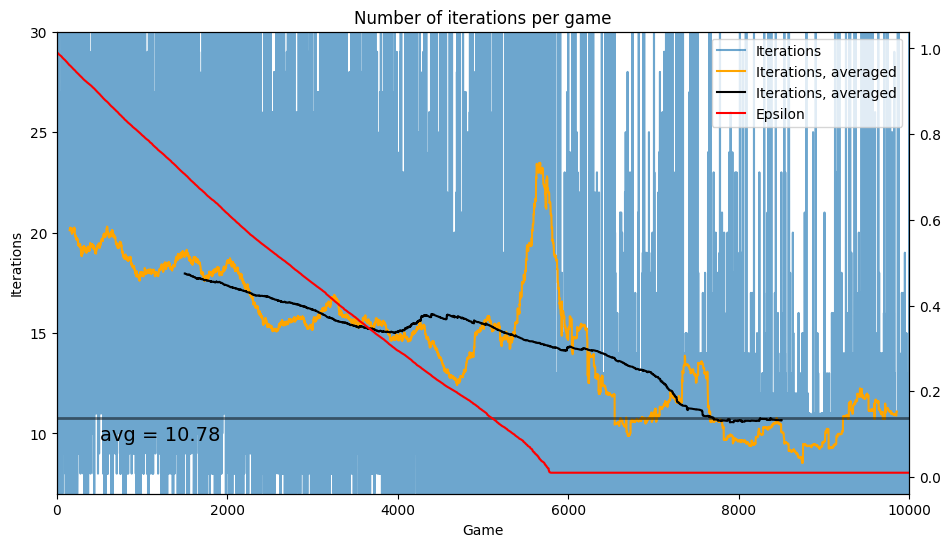

In [7]:
plot_training_history(iters, eps, ylim=30)

## Other visuals

In [8]:
game, color_map = create_same_game()
agent.game = game
print_game(game, color_map)

Units alive: 2
Players: 2:
	Player #0 (1 units): `Ally soldier (100 HP)`  
	Player #1 (1 units): `Enemy soldier (100 HP)`  
	
    0 1 2 3 4
 0            0 
 1            1 
 2            2 
 3       ██   3 
 4         ██ 4 
    0 1 2 3 4

Next move is by player #0: `Ally soldier`


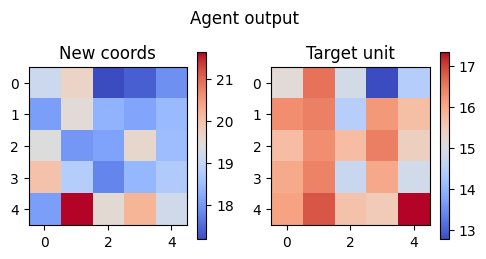

In [9]:
state = game.observe_board()
output = agent.predict(state)

plot_featuremaps(
    output, 
    title='Agent output', 
    fm_names=['New coords', 'Target unit'],
    separate_cbars=True
)

In [10]:
game, color_map = create_same_game()
self_play_loop(agent, game, color_map, reset_epsilon=True, delay=0.5)

Iteration: 1880
Turn made by player #0: `Ally soldier`:
	Unit moves: (0, 3) -> (2, 1);
	And takes aciton `Sword attack` with attributes: {'source_unit': 'Ally soldier', 'target_unit': 'None'}

Units alive: 2
Players: 2:
	Player #0 (1 units): `Ally soldier (100 HP)`  
	Player #1 (1 units): `Enemy soldier (100 HP)`  
	
    0 1 2 3 4
 0 ██    ██   0 
 1            1 
 2            2 
 3            3 
 4            4 
    0 1 2 3 4

Next move is by player #1: `Enemy soldier`

Game interrupted after 1881 iterations
